In [1]:
if (!require("BiocManager", quietly = TRUE)) {
  install.packages("BiocManager")
}

if (!require("ggtree", quietly = TRUE)) {
  BiocManager::install("ggtree")
}

if (!require("aplot", quietly = TRUE)) {
  install.packages("aplot")
}

ggtree v3.10.0 For help: https://yulab-smu.top/treedata-book/

If you use the ggtree package suite in published research, please cite
the appropriate paper(s):

Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam.
ggtree: an R package for visualization and annotation of phylogenetic
trees with their covariates and other associated data. Methods in
Ecology and Evolution. 2017, 8(1):28-36. doi:10.1111/2041-210X.12628

Guangchuang Yu.  Data Integration, Manipulation and Visualization of
Phylogenetic Trees (1st edition). Chapman and Hall/CRC. 2022,
doi:10.1201/9781003279242

Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods
for mapping and visualizing associated data on phylogeny using ggtree.
Molecular Biology and Evolution. 2018, 35(12):3041-3043.
doi:10.1093/molbev/msy194 



In [2]:
library(ggtree)
library(ggplot2)
library(aplot)
library(data.table)

In [3]:
or_genes <- read.csv("data/ORgenes.csv")
or_genes[
  which(or_genes$Species == "Loxodonta Africana"),
  "Species"
] <- "Loxodonta africana"


In [4]:
species_tree <- read.tree("data/phyliptree.phy")
species_tree$tip.label <- as.vector(noquote(gsub(
  "\'",
  "",
  species_tree$tip.label,
  fixed = TRUE
)))
basionym_and_synonym <- list(
  c("Nesogale talazaci", "Microgale talazaci"),
  c("Phataginus tricuspis", "Manis tricuspis"),
  c("Tupaia chinensis", "Tupaia belangeri chinensis")
)
for (i in basionym_and_synonym) {
  species_tree$tip.label[which(species_tree$tip.label == i[1])] <- i[2]
}

# NCBI couldn't find the subspecies
print(setdiff(or_genes$Species, species_tree$tip.label))


[1] "Ceratotherium cottoni"


In [5]:
order_list <- c(
  "Rodentia",
  "Artiodactyla",
  "Primates",
  "Perissodactyla",
  "Carnivora",
  "Chiroptera",
  "Eulipotyphla",
  "Pilosa",
  "Cingulata",
  "Tupaia"
)


In [6]:
species_order <- sapply(order_list, function(i) {
  tips <- species_tree$tip.label[tidytree::offspring(species_tree, i)]
  tips[!is.na(tips)]
})
other_mammals <- setdiff(
  species_tree$tip.label,
  unlist(species_order)
)
write.table(
  other_mammals,
  "data/other_mammals.txt",
  row.names = FALSE,
  col.names = FALSE,
  quote = FALSE
)
species_order[["Other_mammals"]] <- other_mammals


In [7]:
missing_order <- data.frame(
  "values" = "Ceratotherium cottoni",
  "ind" = "Perissodactyla"
)
order_values <- rbind(stack(species_order), missing_order)
colnames(order_values) <- c("Species", "Order")
or_genes_with_order <- merge(or_genes, order_values, by = "Species")

no_missing_value <- or_genes_with_order[
  which(!or_genes_with_order$Species == "Ceratotherium cottoni"),
]

no_missing_value[["Gene_repetoire"]] <- no_missing_value[["Functional"]] +
  no_missing_value[["NonFuctional"]]


In [8]:
tree_with_group <- groupOTU(
  species_tree,
  species_order,
  group_name = "species_order"
)

group_by_activity <- split(
  no_missing_value$Species,
  no_missing_value$Activity.Pattern
)

tree_with_activity <- groupOTU(
  tree_with_group,
  group_by_activity,
  group_name = "activity"
)


In [9]:
order_colors <- list(
  "red",
  "blue",
  "dark green",
  "orange",
  "purple",
  "magenta",
  "navy",
  "green",
  "cyan",
  "dark blue",
  "dark grey"
)
names(order_colors) <- names(species_order)


In [10]:
g <- ggtree(tree_with_activity, aes(color = species_order)) +
  geom_tiplab(align = TRUE) +
  xlim(0, 25) +
  scale_color_manual(values = order_colors) +
  theme(
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 10)
  )


In [11]:
func_gene_bar_plot <- ggplot(
  no_missing_value,
  aes(Functional, Species, fill = Activity.Pattern)
) +
  geom_col() +
  scale_x_reverse() +
  theme(
    axis.title.y = element_blank(),
    axis.text.y = element_blank(),
    axis.ticks.y = element_blank(),
  )


In [12]:
non_func_gene_bar_plot <- ggplot(
  no_missing_value,
  aes(NonFuctional, Species, fill = Activity.Pattern)
) +
  geom_col() +
  theme(
    axis.title.y = element_blank(),
    axis.text.y = element_blank(),
    axis.ticks.y = element_blank()
  )


p <- func_gene_bar_plot %>%
  insert_left(g) %>%
  insert_right(non_func_gene_bar_plot)


ggsave("plots/tree_with_both_stacked.png", p, width = 20, height = 12)


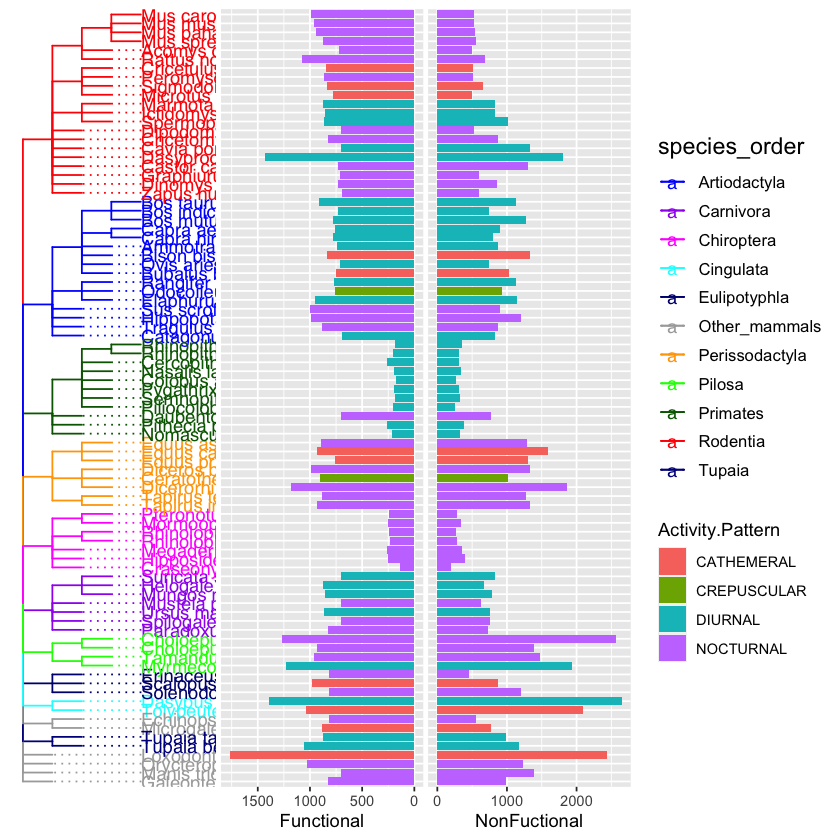

In [13]:
p

In [14]:
primates_df = or_genes_with_order[
  which(or_genes_with_order$Order == "Primates"),
]

bats_df <- or_genes_with_order[
  which(or_genes_with_order$Order == "Chiroptera"),
]


In [15]:
wilcox.test(primates_df$Functional, bats_df$Functional, exact = FALSE)


	Wilcoxon rank sum test with continuity correction

data:  primates_df$Functional and bats_df$Functional
W = 27, p-value = 0.3189
alternative hypothesis: true location shift is not equal to 0


In [16]:
wilcox.test(primates_df$NonFuctional, bats_df$NonFuctional, exact = FALSE)


	Wilcoxon rank sum test with continuity correction

data:  primates_df$NonFuctional and bats_df$NonFuctional
W = 47, p-value = 0.4687
alternative hypothesis: true location shift is not equal to 0
